<a href="https://colab.research.google.com/github/PiyushMankad/TCD-Computer-Vision/blob/master/manakdp%40tcd.ie_CV2_Question2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Question 2.a**

The effective path size used in EPLL is 36x36 which is the smallest of all the leading denoising methods. Therefore, the author sets the patch size of his neural network to be 35x35 for comparison purposes and depth to be 17 for Gaussian distribution going by the norm of (2d+1) for receptive fields.

The DnCNN-3 is used to train a single model for 3 general image denoising tasks


1.   Bling Gaussian Denoising
2.   SISR
3.   JPEG Deblocking



In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Question 2.b**

Using the original value for sigma=25

**Main_test.py**

In [0]:

import argparse
import os, time, datetime
import numpy as np
import torch.nn as nn
import torch.nn.init as init
import torch
from skimage.measure import compare_psnr, compare_ssim
from skimage.io import imread, imsave


In [10]:

# run this to test the model


def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--set_dir', default="../content/drive/My Drive/Colab Notebooks/data/Test", type=str, help='directory of test dataset')
    parser.add_argument('--set_names', default=['Set68'], help='directory of test dataset')
    parser.add_argument('--sigma', default=25, type=int, help='noise level')
    parser.add_argument('--model_path', default="/content/drive/My Drive/Colab Notebooks/models/model_000.pth ", type=str, help='the model name')
    parser.add_argument('--result_dir', default="/content/drive/My Drive/Colab Notebooks/results", type=str, help='directory of test dataset')
    parser.add_argument('--save_result', default=True, action='store_true', help='save the denoised image')
    return parser.parse_args(args=[])


def log(*args, **kwargs):
     print("\n",datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S:"), *args, **kwargs)


def save_result(result, path):
    path = path if path.find('.') != -1 else path+'.png'
    ext = os.path.splitext(path)[-1]
    if ext in ('.txt', '.dlm'):
        np.savetxt(path, result, fmt='%2.4f')
    else:
        imsave(path, np.uint8(np.clip(result*255.0, 0, 255)))


def show(x, title=None, cbar=False, figsize=None):
    import matplotlib.pyplot as plt
    plt.figure(figsize=figsize)
    plt.imshow(x, interpolation='nearest', cmap='gray')
    if title:
        plt.title(title)
    if cbar:
        plt.colorbar()
    plt.show()


class DnCNN(nn.Module):

    def __init__(self, depth=17, n_channels=64, image_channels=1, use_bnorm=True, kernel_size=3):
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        layers = []
        layers.append(nn.Conv2d(in_channels=image_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=True))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(depth-2):
            layers.append(nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(n_channels))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=n_channels, out_channels=image_channels, kernel_size=kernel_size, padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers)
        self._initialize_weights()

    def forward(self, x):
        y = x
        out = self.dncnn(x)
        return y-out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.orthogonal_(m.weight)
                print('init weight')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)


def main():  
    args = parse_args()
    # model = torch.load(args.model_path)
    model = torch.load("/content/drive/My Drive/Colab Notebooks/models/model_000.pth")
    log('load trained model')

    model.eval()  # evaluation mode
    print("\n\n Model evaluated")

    if torch.cuda.is_available():
        model = model.cuda()

    if not os.path.exists(args.result_dir):
        os.mkdir(args.result_dir)

    for set_cur in args.set_names:
        # print("set_cur",set_cur)

        if not os.path.exists(os.path.join(args.result_dir, set_cur)):
            os.mkdir(os.path.join(args.result_dir, set_cur))
        psnrs = []
        ssims = []

        for im in os.listdir(os.path.join(args.set_dir, set_cur)):
            if im.endswith(".jpg") or im.endswith(".bmp") or im.endswith(".png"):

                x = np.array(imread(os.path.join(args.set_dir, set_cur, im)), dtype=np.float32)/255.0
                # print("x.shape",x.shape)
                np.random.seed(seed=0)  # for reproducibility
                y = x + np.random.normal(0, args.sigma/255.0, x.shape)  #(location, scale, size)# Add Gaussian noise without clipping
                y = y.astype(np.float32)
                y_ = torch.from_numpy(y).view(1, -1, y.shape[0], y.shape[1])
                # print("y.shape",y.shape)

                torch.cuda.synchronize()
                start_time = time.time()
                y_ = y_.cuda()
                x_ = model(y_)  # inference
                x_ = x_.view(y.shape[0], y.shape[1])
                x_ = x_.cpu()
                x_ = x_.detach().numpy().astype(np.float32)
                torch.cuda.synchronize()
                elapsed_time = time.time() - start_time
                # print('%10s : %10s : %2.4f second' % (set_cur, im, elapsed_time))

                psnr_x_ = compare_psnr(x, x_)
                ssim_x_ = compare_ssim(x, x_)
                if args.save_result:
                    name, ext = os.path.splitext(im)
                    #show(np.hstack((y, x_)))  # show the image
                    save_result(x_, path=os.path.join(args.result_dir, set_cur, name+'_dncnn'+ext))  # save the denoised image
                psnrs.append(psnr_x_)
                ssims.append(ssim_x_)
        psnr_avg = np.mean(psnrs)
        ssim_avg = np.mean(ssims)
        psnrs.append(psnr_avg)
        ssims.append(ssim_avg)
        if args.save_result:
            save_result(np.hstack((psnrs, ssims)), path=os.path.join(args.result_dir, set_cur, 'results.txt'))
        log('Datset: {0:10s} \n  PSNR = {1:2.2f}dB, SSIM = {2:1.4f}'.format(set_cur, psnr_avg, ssim_avg))

## calling the above function
main()



/usr/local/lib/python3.6/dist-packages/torch/serialization.py:459: UserWarning: Couldn't retrieve source code for container of type DnCNN. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/u


 2019-11-24 22:07:11: load trained model


 Model evaluated

 2019-11-24 22:07:20: Datset: Set68      
  PSNR = 29.18dB, SSIM = 0.9009


# **Question 2.b**

Using the assigned sigma value=36

In [11]:
def using_sigma(sigma,model__path=0):
  args = parse_args()
  # model = torch.load(args.model_path)
  try:
    ## used for question 2.c
    model = torch.load(model__path)
  except:
    model = torch.load("/content/drive/My Drive/Colab Notebooks/models/model_000.pth")
  
  log('load trained model')

  model.eval()  # evaluation mode
  print("\n\n Model evaluated")

  if torch.cuda.is_available():
      model = model.cuda()

  if not os.path.exists(args.result_dir):
      os.mkdir(args.result_dir)
      
  for set_cur in args.set_names:
      # print("set_cur",set_cur)

      if not os.path.exists(os.path.join(args.result_dir, set_cur)):
          os.mkdir(os.path.join(args.result_dir, set_cur))
      psnrs = []
      ssims = []

      for im in os.listdir(os.path.join(args.set_dir, set_cur)):
          if im.endswith(".jpg") or im.endswith(".bmp") or im.endswith(".png"):

              x = np.array(imread(os.path.join(args.set_dir, set_cur, im)), dtype=np.float32)/255.0
              np.random.seed(seed=0)  # for reproducibility
              y = x + np.random.normal(0, sigma/255.0, x.shape)  # Add Gaussian noise without clipping
              y = y.astype(np.float32)
              y_ = torch.from_numpy(y).view(1, -1, y.shape[0], y.shape[1])

              torch.cuda.synchronize()
              start_time = time.time()
              y_ = y_.cuda()
              x_ = model(y_)  # inference
              x_ = x_.view(y.shape[0], y.shape[1])
              x_ = x_.cpu()
              x_ = x_.detach().numpy().astype(np.float32)
              torch.cuda.synchronize()
              elapsed_time = time.time() - start_time
              # print('%10s : %10s : %2.4f second' % (set_cur, im, elapsed_time))

              psnr_x_ = compare_psnr(x, x_)
              ssim_x_ = compare_ssim(x, x_)
              if args.save_result:
                  name, ext = os.path.splitext(im)
                  #show(np.hstack((y, x_)))  # show the image
                  save_result(x_, path=os.path.join(args.result_dir, set_cur, name+'_dncnn'+ext))  # save the denoised image
              psnrs.append(psnr_x_)
              ssims.append(ssim_x_)
      psnr_avg = np.mean(psnrs)
      ssim_avg = np.mean(ssims)
      psnrs.append(psnr_avg)
      ssims.append(ssim_avg)
      if args.save_result:
          save_result(np.hstack((psnrs, ssims)), path=os.path.join(args.result_dir, set_cur, 'results.txt'))
      log('Datset: {0:10s} \n  PSNR = {1:2.2f}dB, SSIM = {2:1.4f}'.format(set_cur, psnr_avg, ssim_avg))
      # print(set_cur, psnr_avg, ssim_avg)

sigma = 36
## above function call
using_sigma(sigma)


 2019-11-24 22:07:20: load trained model


 Model evaluated


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:459: UserWarning: Couldn't retrieve source code for container of type DnCNN. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/u


 2019-11-24 22:07:25: Datset: Set68      
  PSNR = 22.03dB, SSIM = 0.5928


# **Question 2.c**

main_train.py



In [0]:
# run this to train the model

import argparse
import re
import os, glob, datetime, time
import numpy as np
import torch
import torch.nn as nn
from torch.nn.modules.loss import _Loss
import torch.nn.init as init
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
# import data_generator as dg
# from tensorflow.keras.preprocessing.image import ImageDataGenerator as dg
# from data_generator import DenoisingDataset



import glob
import cv2
import numpy as np
from torch.utils.data import Dataset
import torch

patch_size, stride = 40, 10
aug_times = 1
scales = [1, 0.9, 0.8, 0.7]
batch_size = 128


class DenoisingDataset(Dataset):
    """Dataset wrapping tensors.
    Arguments:
        xs (Tensor): clean image patches
        sigma: noise level, e.g., 25
    """
    def __init__(self, xs, sigma):
        super(DenoisingDataset, self).__init__()
        self.xs = xs
        self.sigma = sigma

    def __getitem__(self, index):
        batch_x = self.xs[index]
        noise = torch.randn(batch_x.size()).mul_(self.sigma/255.0)
        batch_y = batch_x + noise
        return batch_y, batch_x

    def __len__(self):
        return self.xs.size(0)


def show(x, title=None, cbar=False, figsize=None):
    import matplotlib.pyplot as plt
    plt.figure(figsize=figsize)
    plt.imshow(x, interpolation='nearest', cmap='gray')
    if title:
        plt.title(title)
    if cbar:
        plt.colorbar()
    plt.show()


def data_aug(img, mode=0):
    # data augmentation
    if mode == 0:
        return img
    elif mode == 1:
        return np.flipud(img)
    elif mode == 2:
        return np.rot90(img)
    elif mode == 3:
        return np.flipud(np.rot90(img))
    elif mode == 4:
        return np.rot90(img, k=2)
    elif mode == 5:
        return np.flipud(np.rot90(img, k=2))
    elif mode == 6:
        return np.rot90(img, k=3)
    elif mode == 7:
        return np.flipud(np.rot90(img, k=3))


def gen_patches(file_name):
    # get multiscale patches from a single image
    img = cv2.imread(file_name, 0)  # gray scale
    h, w = img.shape
    patches = []
    for s in scales:
        h_scaled, w_scaled = int(h*s), int(w*s)
        img_scaled = cv2.resize(img, (w_scaled, h_scaled), interpolation=cv2.INTER_CUBIC)
        # extract patches
        for i in range(0, h_scaled-patch_size+1, stride):
            for j in range(0, w_scaled-patch_size+1, stride):
                x = img_scaled[i:i+patch_size, j:j+patch_size]
                for k in range(0, aug_times):
                    x_aug = data_aug(x, mode=np.random.randint(0, 8))
                    patches.append(x_aug)
    return patches


def datagenerator(data_dir='data/Train400', verbose=False):
    # generate clean patches from a dataset
    file_list = glob.glob(data_dir+'/*.jpg')  # get name list of all .jpg files
    # initrialize
    data = []
    # generate patches
    for i in range(len(file_list)):
        patches = gen_patches(file_list[i])
        for patch in patches:    
            data.append(patch)
        if verbose:
            print(str(i+1) + '/' + str(len(file_list)) + ' is done')
    data = np.array(data, dtype='uint8')
    data = np.expand_dims(data, axis=3)
    discard_n = len(data)-len(data)//batch_size*batch_size  # because of batch namalization
    data = np.delete(data, range(discard_n), axis=0)
    print('training data finished')
    return data


# Params
parser = argparse.ArgumentParser(description='PyTorch DnCNN')
parser.add_argument('--batch_size', default=128, type=int, help='batch size')
parser.add_argument('--train_data', default="/content/drive/My Drive/Colab Notebooks/data/Train400", type=str, help='path of train data')
parser.add_argument('--sigma', default=36, type=int, help='noise level')
parser.add_argument('--epochs', default=1, type=int, help='number of train epochs')
parser.add_argument('--lr', default=0.0001, type=float, help='initial learning rate for Adam')
args = parser.parse_args(args=[])

batch_size = args.batch_size
cuda = torch.cuda.is_available()
n_epochs = args.epochs
sigma = args.sigma


save_dir = 'models'

if not os.path.exists(save_dir):
    os.mkdir(save_dir)


class DnCNN(nn.Module):
    def __init__(self, depth=17, n_channels=64, image_channels=1, use_bnorm=True, kernel_size=3):
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        layers = []

        layers.append(nn.Conv2d(in_channels=image_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=True))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(depth-2):
            layers.append(nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(n_channels))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=n_channels, out_channels=image_channels, kernel_size=kernel_size, padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers)
        self._initialize_weights()

    def forward(self, x):
        y = x
        out = self.dncnn(x)
        return y-out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.orthogonal_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)


class sum_squared_error(_Loss):
    """
    Definition: sum_squared_error = 1/2 * nn.MSELoss(reduction = 'sum')
    The backward is defined as: input-target
    """
    def __init__(self, size_average=None, reduce=None, reduction='sum'):
        super(sum_squared_error, self).__init__(size_average, reduce, reduction)

    def forward(self, input, target):
        return torch.nn.functional.mse_loss(input, target, size_average=None, reduce=None, reduction='sum').div_(2)


def findLastCheckpoint(save_dir):
    file_list = glob.glob(os.path.join(save_dir, 'model_*.pth'))
    if file_list:
        epochs_exist = []
        for file_ in file_list:
            result = re.findall(".*model_(.*).pth.*", file_)
            epochs_exist.append(int(result[0]))
        initial_epoch = max(epochs_exist)
    else:
        initial_epoch = 0
    return initial_epoch


def log(*args, **kwargs):
     print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S:"), *args, **kwargs)


def main2():
    # model selection
    print('===> Building model')
    model = DnCNN()

    
    initial_epoch = findLastCheckpoint(save_dir=save_dir)  # load the last model in matconvnet style
    if initial_epoch > 0 or os.path.isfile(os.path.join(save_dir, 'model_%03d.pth' % initial_epoch)):
        print('resuming by loading epoch %03d' % initial_epoch)
        model = torch.load(os.path.join(save_dir, 'model_%03d.pth' % initial_epoch))
    model.train()
    criterion = sum_squared_error()
    if cuda:
        model = model.cuda()

    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    scheduler = MultiStepLR(optimizer, milestones=[15], gamma=0.1)  # learning rates
    for epoch in range(initial_epoch, n_epochs):

        scheduler.step(epoch)  # step to the learning rate in this epcoh
        xs = datagenerator(data_dir="/content/drive/My Drive/Colab Notebooks/data/Train400")
        xs = xs.astype('float32')/255.0
        print("xs.shape",xs.shape,type(xs))

        xs = torch.from_numpy(xs.transpose((0, 3, 1, 2)))  # tensor of the clean patches, NxCxHxW
        DDataset = DenoisingDataset(xs, sigma)
        DLoader = DataLoader(dataset=DDataset, num_workers=0, drop_last=True, batch_size=batch_size, shuffle=True)
        epoch_loss = 0
        start_time = time.time()
        print("DLoader",DLoader)

        for n_count, batch_yx in enumerate(DLoader):
            optimizer.zero_grad()
            if cuda:
                batch_x, batch_y = batch_yx[1].cuda(), batch_yx[0].cuda()
            else:
                batch_x, batch_y = batch_yx[1], batch_yx[0]
            loss = criterion(model(batch_y), batch_x)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
            if n_count % 100 == 0:
                print('%4d %4d / %4d loss = %2.4f' % (epoch+1, n_count, xs.size(0)//batch_size, loss.item()/batch_size))
        elapsed_time = time.time() - start_time

        log('epcoh = %4d , loss = %4.4f , time = %4.2f s' % (epoch+1, epoch_loss/n_count, elapsed_time))
        np.savetxt('train_result.txt', np.hstack((epoch+1, epoch_loss/n_count, elapsed_time)), fmt='%2.4f')
        torch.save(model, os.path.join(save_dir, 'new_model_001.pth'))
if __name__ == '__main__':
  # main2()
  pass


# **Question 2.c** (Continuation)

**Testing the trained model**

Fine-Tuned Model Path: `"new_model_001.pth"`


In [13]:
## funcion call with the given sigma and trained model
using_sigma(36,"/content/models/new_model_001.pth")

2019-11-24 22:07:26: load trained model


 Model evaluated
2019-11-24 22:07:32: Datset: Set68      
  PSNR = 26.79dB, SSIM = 0.8402


# **Question 2.d**

Used sigma = 36 (assigned) in both the denoising image



---


pretrained:  PSNR = 19.98dB, SSIM = 0.7070

Fine tuned:  PSNR = 20.18dB, SSIM = 0.5772


In [14]:
def denoising_image(sigma,model__path,image,imtype):
  args = parse_args()
  model = torch.load(model__path)
  
  
  model.eval()  # evaluation mode

  if torch.cuda.is_available():
      model = model.cuda()

  if not os.path.exists(args.result_dir):
      os.mkdir(args.result_dir)
      
  for set_cur in args.set_names:

      if not os.path.exists(os.path.join(args.result_dir, set_cur)):
          os.mkdir(os.path.join(args.result_dir, set_cur))
      psnrs = []
      ssims = []

      ## Single image reading
      x = np.array(imread(image), dtype=np.float32)/255.0
      np.random.seed(seed=0)  # for reproducibility
      y = x + np.random.normal(0, sigma/255.0, x.shape)  # Add Gaussian noise without clipping
      y = y.astype(np.float32)
      y_ = torch.from_numpy(y).view(1, -1, y.shape[0], y.shape[1])

      torch.cuda.synchronize()
      start_time = time.time()
      y_ = y_.cuda()
      x_ = model(y_)  # inference
      x_ = x_.view(y.shape[0], y.shape[1])
      x_ = x_.cpu()
      x_ = x_.detach().numpy().astype(np.float32)
      torch.cuda.synchronize()
      elapsed_time = time.time() - start_time
      # print('%10s : %10s : %2.4f second' % (set_cur, im, elapsed_time))

      psnr_x_ = compare_psnr(x, x_)
      ssim_x_ = compare_ssim(x, x_)
      
      ## saving your denoised image File
      name, ext = os.path.splitext(image)
      #show(np.hstack((y, x_)))  # show the image
      save_result(x_, path="MANKADP@TCD.IE_062_{}.png".format(imtype)) #MANKADP@TCD.IE_062 # save the denoised image
      
      psnrs.append(psnr_x_)
      ssims.append(ssim_x_)
      psnr_avg = np.mean(psnrs)
      ssim_avg = np.mean(ssims)

      psnrs.append(psnr_avg)
      ssims.append(ssim_avg)
      if args.save_result:
          save_result(np.hstack((psnrs, ssims)), path=os.path.join(args.result_dir, set_cur, 'results.txt'))
      log('Datset: {0:10s} \n  PSNR = {1:2.2f}dB, SSIM = {2:1.4f}'.format(set_cur, psnr_avg, ssim_avg))
      print("\n")


print("\nDenoising image on the pretrained model")
denoising_image(36,"/content/drive/My Drive/Colab Notebooks/models/model_000.pth","/content/drive/My Drive/Colab Notebooks/Additional Files/MANKADP@TCD.IE_062.png","pretrained")
print("\nDenoising image on the Fine-Tuned model")
denoising_image(36,"/content/models/new_model_001.pth","/content/drive/My Drive/Colab Notebooks/Additional Files/MANKADP@TCD.IE_062.png","clean")


Denoising image on the pretrained model
2019-11-24 22:07:32: Datset: Set68      
  PSNR = 19.98dB, SSIM = 0.7070



Denoising image on the Fine-Tuned model
2019-11-24 22:07:32: Datset: Set68      
  PSNR = 20.18dB, SSIM = 0.5727




/usr/local/lib/python3.6/dist-packages/torch/serialization.py:459: UserWarning: Couldn't retrieve source code for container of type DnCNN. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/u

# **Question 2.e**

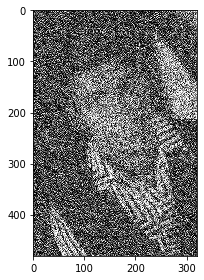

In [17]:
## training for noise output

class DnCNN_noise(nn.Module):
    def __init__(self, depth=17, n_channels=64, image_channels=1, use_bnorm=True, kernel_size=3):
        super(DnCNN_noise, self).__init__()
        kernel_size = 3
        padding = 1
        layers = []

        layers.append(nn.Conv2d(in_channels=image_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=True))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(depth-2):
            layers.append(nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(n_channels))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=n_channels, out_channels=image_channels, kernel_size=kernel_size, padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers)
        self._initialize_weights()

    def forward(self, x):
        y = x
        out = self.dncnn(x)
        return out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.orthogonal_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)


class sum_squared_error(_Loss):
    """
    Definition: sum_squared_error = 1/2 * nn.MSELoss(reduction = 'sum')
    The backward is defined as: input-target
    """
    def __init__(self, size_average=None, reduce=None, reduction='sum'):
        super(sum_squared_error, self).__init__(size_average, reduce, reduction)

    def forward(self, input, target):
        return torch.nn.functional.mse_loss(input, target, size_average=None, reduce=None, reduction='sum').div_(2)


def datagenerator(data_dir='data/Train400', verbose=False):
    # generate clean patches from a dataset
    file_list = glob.glob(data_dir+'/*.jpg')  # get name list of all .jpg files
    # initrialize
    data = []
    # generate patches
    for i in range(len(file_list)):
        patches = gen_patches(file_list[i])
        for patch in patches:    
            data.append(patch)
        if verbose:
            print(str(i+1) + '/' + str(len(file_list)) + ' is done')
    data = np.array(data, dtype='uint8')
    data = np.expand_dims(data, axis=3)
    discard_n = len(data)-len(data)//batch_size*batch_size  # because of batch namalization
    data = np.delete(data, range(discard_n), axis=0)
    print('training data finished')
    return data


def training():
    # model selection
    print('===> Building Noise model')
    model = DnCNN_noise()
    
    model.train()
    criterion = sum_squared_error()
    if cuda:
        model = model.cuda()
    else:
    	model = model
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    scheduler = MultiStepLR(optimizer, milestones=[15], gamma=0.1)  # learning rates
    for epoch in range(0, n_epochs):

        scheduler.step(epoch)  # step to the learning rate in this epcoh
        xs = datagenerator(data_dir=args.train_data)
        xs = xs.astype('float32')/255.0
        xs = torch.from_numpy(xs.transpose((0, 3, 1, 2)))  # tensor of the clean patches, NXCXHXW
        DDataset = DenoisingDataset(xs, sigma)
        DLoader = DataLoader(dataset=DDataset, num_workers=0, drop_last=True, batch_size=batch_size, shuffle=True)
        epoch_loss = 0
        start_time = time.time()

        for n_count, batch_yx in enumerate(DLoader):
            optimizer.zero_grad()
            if cuda:
                batch_x, batch_y = batch_yx[1].cuda(), batch_yx[0].cuda()
            else:
                batch_x, batch_y = batch_yx[1], batch_yx[0]
            loss = criterion(model(batch_y), batch_x)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
            if n_count % 100 == 0:
                print('%4d %4d / %4d loss = %2.4f' % (epoch+1, n_count, xs.size(0)//batch_size, loss.item()/batch_size))
        elapsed_time = time.time() - start_time

        log('epcoh = %4d , loss = %4.4f , time = %4.2f s' % (epoch+1, epoch_loss/n_count, elapsed_time))
        # np.savetxt('train_result.txt', np.hstack((epoch+1, epoch_loss/n_count, elapsed_time)), fmt='%2.4f')
        torch.save(model, os.path.join(save_dir, 'noise_model.pth'))





import struct
## training the noise model
# training()
print("\n Generating the noise from the image on the noise model")
print("\n Centering the image at 127")
denoising_image(127,"/content/models/noise_model.pth","/content/drive/My Drive/Colab Notebooks/Additional Files/MANKADP@TCD.IE_062.png","noise")

img = imread("MANKADP@TCD.IE_062_noise.png")
stddev = np.std(np.array(img))
print("Standard Deviation",stddev)
from skimage.io import imshow
imshow(img)